Hey!

In [2]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scanpy as sc
import sklearn.decomposition #import TruncatedSVD
import scipy 
import sparse, io
import os 
matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

os.chdir('/lunarc/nobackup/projects/regen_immuno/tools/samap/transcriptomes/')
hs_adata=anndata.read_h5ad('/lunarc/nobackup/projects/regen_immuno/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/local.h5ad')

In [14]:
# Set a random seed for reproducibility
np.random.seed(42)

# Identify the unique clusters in the 'free_annotation' column
unique_clusters = hs_adata.obs['free_annotation'].unique()

# Create a DataFrame to store the selected cell indices
selected_indices = []

# Determine the number of cells to select from each cluster
total_cells_to_keep = int(0.3 * len(hs_adata.obs))
cluster_sizes = hs_adata.obs['free_annotation'].value_counts()

# Loop through each cluster and select proportionate cells
for cluster in unique_clusters:
    cluster_indices = hs_adata.obs[hs_adata.obs['free_annotation'] == cluster].index
    n_cells_to_keep = int(cluster_sizes[cluster] / len(hs_adata.obs) * total_cells_to_keep)
    selected_indices.extend(np.random.choice(cluster_indices, n_cells_to_keep, replace=False))

# Create a new AnnData object containing only the selected cells
hs_adata_selected = hs_adata[selected_indices].copy()

# Print information about the selected cells
print("Original number of cells:{}".format(hs_adata.n_obs))
print("Number of selected cells:{}".format(hs_adata_selected.n_obs))

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Original number of cells:264824
Number of selected cells:79373


The cell selection method provided involves selecting an equal number of cells from each cluster in a single-cell dataset, ensuring balanced representation and preventing dominance by larger clusters during downstream analysis.

In [15]:
hs_adata.obs

,tissue_in_publication,assay_ontology_term_id,donor_id,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,7633.0,2259,macrophage,Monocyte/Macrophage,True,immune,...,HsapDv:0000161,HANCESTRO:0005,macrophage,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,2858.0,1152,monocyte,Monocyte,True,immune,...,HsapDv:0000161,HANCESTRO:0005,monocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,10395.0,2598,macrophage,Monocyte/Macrophage,True,immune,...,HsapDv:0000161,HANCESTRO:0005,macrophage,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,6610.0,2125,liver dendritic cell,Dendritic cell,True,immune,...,HsapDv:0000161,HANCESTRO:0005,liver dendritic cell,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAAGAACGTTTCTTAC_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,9387.0,2345,macrophage,Monocyte/Macrophage,True,immune,...,HsapDv:0000161,HANCESTRO:0005,macrophage,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P5_S365,Vasculature,EFO:0008931,TSP2,aorta,37347.0,395,macrophage,macrophage,True,immune,...,HsapDv:0000155,HANCESTRO:0016,macrophage,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P6_S366,Vasculature,EFO:0008931,TSP2,aorta,111047.0,769,macrophage,macrophage,True,immune,...,HsapDv:0000155,HANCESTRO:0016,macrophage,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P7_S367,Vasculature,EFO:0008931,TSP2,aorta,140634.0,2468,macrophage,macrophage,True,immune,...,HsapDv:0000155,HANCESTRO:0016,macrophage,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P8_S368,Vasculature,EFO:0008931,TSP2,aorta,176268.0,2700,macrophage,macrophage,True,immune,...,HsapDv:0000155,HANCESTRO:0016,macrophage,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage


In [16]:
import pandas as pd

dataset=pd.read_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/gene&prot.csv")
hs_conversion =dataset.dropna()
print(hs_conversion.head(10))

     Gene stable ID Protein stable ID version
5   ENSG00000198888         ENSP00000354687.2
9   ENSG00000198763         ENSP00000355046.4
15  ENSG00000198804         ENSP00000354499.2
18  ENSG00000198712         ENSP00000354876.1
20  ENSG00000228253         ENSP00000355265.1
21  ENSG00000198899         ENSP00000354632.2
22  ENSG00000198938         ENSP00000354982.2
24  ENSG00000198840         ENSP00000355206.2
26  ENSG00000212907         ENSP00000354728.1
27  ENSG00000198886         ENSP00000354961.2


In [3]:
hs_res = ('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/Tabula_immune.h5ad')
hs_adata_selected.write(hs_res)
# Display variable (gene) names from the selected AnnData object
print("Gene names:")
print(hs_adata_selected.var_names)

NameError: name 'hs_adata_selected' is not defined

In [ ]:
#Dont have access for some reason
#!wget -O samap_intermediate/hs_to_pw.txt https://lu.box.com/shared/static/fpb5tk1ba1dzs7re1pthlh846bq0ay80.txt
#!wget -O samap_intermediate/pw_to_hs.txt https://lu.box.com/shared/static/sytvvnhkj31tjixn1oidfvttxvjeq1f7.txt

In [18]:
#Importing the reciprocal Blast results
#Humans to pw
hs_pw= pd.read_table("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/hs_to_pw.txt")
hs_pw_header = ['ensp', 'pw_pep', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
hs_pw.columns =hs_pw_header
#pw to Humans
pw_hs =pd.read_table("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/pw_to_hs.txt")
pw_hs_header = ['pw_pep', 'ensp', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
pw_hs.columns =pw_hs_header

#Creating a mapping dict
mapping_dict = hs_conversion.set_index('Protein stable ID version')['Gene stable ID'].to_dict()

#Mapping the columns of the blast results to the gene ids
hs_pw['ensp'] = hs_pw['ensp'].map(mapping_dict).fillna(hs_pw['ensp'])
pw_hs['ensp'] =pw_hs['ensp'].map(mapping_dict).fillna(hs_pw['ensp'])

In [4]:
import scanpy as sc
spleen_data=sc.read_h5ad('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/spleenR1.h5ad')
spleen_genes = spleen_data.var_names
spleen_genes=pd.DataFrame(spleen_genes)
spleen_genes.columns = ['Gene_Names']
print(spleen_genes)
print("Number of cells in spleen data:",spleen_data.n_obs)

      Gene_Names
0           POL3
1      gene26597
2      gene26598
3           SPX2
4      gene26599
...          ...
65592     NU5M.1
65593     COX1.1
65594     COX1.2
65595       NU2M
65596  gene65597

[65597 rows x 1 columns]
Number of cells in spleen data: 19045


In [20]:
header=['gene_id','gene_name','Gene_expr']
spleen_id_name = pd.read_table('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/features.tsv',names=header)
spleen_id_name          

,gene_id,gene_name,Gene_expr
0,gene26596,POL3,Gene Expression
1,gene26597,gene26597,Gene Expression
2,gene26598,gene26598,Gene Expression
3,gene26595,SPX2,Gene Expression
4,gene26599,gene26599,Gene Expression
...,...,...,...
65592,gene65593,NU5M,Gene Expression
65593,gene65594,COX1,Gene Expression
65594,gene65595,COX1,Gene Expression
65595,gene65596,NU2M,Gene Expression


In [10]:
annot_mapping=pd.read_table('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/annot_mapping.csv')
annot_mapping

,gene_id,transcript_id,sprot_Top_BLASTX_hit,prot_id,EggNM.Preferred_name
0,gene65541,mRNA174710,.,mRNA174710.pep,.
1,gene65590,mRNA174774,.,mRNA174774.pep,.
2,gene65569,mRNA174746,"TSN31_DANRE^TSN31_DANRE^Q:142-588,H:1-149^73.1...",mRNA174746.pep,TSPAN31
3,gene65568,mRNA174743,"YG31B_YEAST^YG31B_YEAST^Q:1973-3145,H:638-1008...",mRNA174743.pep,.
4,gene65568,mRNA174744,"YG31B_YEAST^YG31B_YEAST^Q:1973-3145,H:638-1008...",mRNA174744.pep,.
...,...,...,...,...,...
174777,gene65485,mRNA174600,"E41L3_MOUSE^E41L3_MOUSE^Q:93-1838,H:1-620^75.8...",mRNA174600.pep,EPB41L3
174778,gene65485,mRNA174599,"E41L3_MOUSE^E41L3_MOUSE^Q:93-1841,H:1-620^75.7...",mRNA174599.pep,EPB41L3
174779,gene65485,mRNA174598,"E41L3_MOUSE^E41L3_MOUSE^Q:229-1962,H:6-620^75....",mRNA174598.pep,EPB41L3
174780,gene65485,mRNA174602,"E41L3_MOUSE^E41L3_MOUSE^Q:93-1931,H:1-620^80.7...",mRNA174602.pep,EPB41L3


In [21]:
mapping_dict_anno =annot_mapping.set_index('prot_id')['gene_id'].to_dict()
hs_pw['pw_pep'] = hs_pw['pw_pep'].map(mapping_dict_anno).fillna(hs_pw['pw_pep'])
hs_pw

,ensp,pw_pep,3,4,5,6,7,8,9,10,11,12
0,ENSG00000211821,gene46259,38.554,83,51,0,30,112,94,176,1.390000e-15,72.4
1,ENSG00000211821,gene46259,38.554,83,51,0,30,112,94,176,1.470000e-15,72.4
2,ENSG00000211821,gene46255,36.522,115,64,3,8,115,61,173,1.600000e-15,70.9
3,ENSG00000211821,gene46255,36.522,115,64,3,8,115,61,173,5.580000e-15,70.5
4,ENSG00000211821,gene7213,30.172,116,75,3,1,111,39,153,2.360000e-09,53.5
...,...,...,...,...,...,...,...,...,...,...,...,...
5630582,ENSG00000116786,gene47382,68.880,1009,264,5,1,978,1,990,0.000000e+00,1398.0
5630583,ENSG00000116786,gene47382,68.880,1009,263,6,1,978,1,989,0.000000e+00,1392.0
5630584,ENSG00000116786,gene47382,67.393,1009,259,6,1,978,1,970,0.000000e+00,1354.0
5630585,ENSG00000116786,gene44928,28.177,181,107,3,1,161,11,188,7.700000e-13,74.7


In [22]:
pw_hs['pw_pep']=pw_hs['pw_pep'].map(mapping_dict_anno).fillna(pw_hs['pw_pep'])
pw_hs

,pw_pep,ensp,3,4,5,6,7,8,9,10,11,12
0,gene65569,ENSG00000135452,79.808,104,21,0,1,104,1,104,2.030000e-53,166.0
1,gene65569,ENSG00000135452,79.808,104,21,0,1,104,1,104,3.360000e-53,166.0
2,gene65569,ENSG00000106537,59.286,140,55,2,1,139,1,139,4.180000e-42,140.0
3,gene65569,ENSG00000135452,86.154,65,9,0,1,65,1,65,2.080000e-30,107.0
4,gene65569,ENSG00000135452,51.389,72,32,1,79,150,1,69,4.920000e-19,77.4
...,...,...,...,...,...,...,...,...,...,...,...,...
5239034,gene65485,ENSG00000139926,21.687,249,161,8,140,354,41,289,4.210000e-07,55.1
5239035,gene65485,ENSG00000153303,22.553,235,157,7,137,347,8,241,4.310000e-07,55.1
5239036,gene65485,ENSG00000007944,31.915,94,61,2,301,393,4,95,5.820000e-07,53.5
5239037,gene65485,ENSG00000171914,25.170,147,106,2,168,310,174,320,9.790000e-07,54.7


In [23]:
spleen_genes_ids=spleen_id_name['gene_id']
spleen_genes_ids

0        gene26596
1        gene26597
2        gene26598
3        gene26595
4        gene26599
           ...    
65592    gene65593
65593    gene65594
65594    gene65595
65595    gene65596
65596    gene65597
Name: gene_id, Length: 65597, dtype: object

Starting the process from the SAMap vignett

In [3]:
from samap.mapping import SAMAP
from samap.analysis import (get_mapping_scores, GenePairFinder,
                            sankey_plot, chord_plot, CellTypeTriangles,
                            ParalogSubstitutions, FunctionalEnrichment,
                            convert_eggnog_to_homologs, GeneTriangles)
from samalg import SAM

In [ ]:
org1 ='/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Pw_spleenR1.h5ad'
org2 ='/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Tabula_immune.h5ad'
filenames = {'pw':org1,'hs':org2}

sm = SAMAP(
        filenames,
        f_maps = 'maps/',
        save_processed=True, #if False, do not save the processed results to `*_pr.h5ad`
        keys = {'pw':'seurat_clusters','hs':'free_annotation'},
   )

In [ ]:
sm.run()
samap = sm.samap

In [6]:
#from samap.utils import save_samap
#save_samap(sm, '/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/pw_hs_spl_SAM.pkl')

#To load in SAMAP directly
import pickle
with open('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/pw_hs_spl_SAM.pkl', 'rb') as f:
    sm = pickle.load(f)
samap =sm.samap

In [ ]:
samap.adata.obs

In [20]:
keys = {'pw':'seurat_clusters','hs':'tissue'}
D,MappingTable = get_mapping_scores(sm,keys,n_top = 0)
D.head()
MappingTable.head()
samap.adata.obs

,pw_orig.ident,pw_soup_assign,pw_soup_status,pw_scds_DropletType,pw_combined_status,pw_RNA_snn_res.0.8,pw_seurat_clusters,pw_ident,hs_tissue_in_publication,hs_assay_ontology_term_id,...,hs_assay,hs_disease,hs_organism,hs_sex,hs_tissue,hs_self_reported_ethnicity,hs_development_stage,batch,species,seurat_clusters;tissue_mapping_scores
AAACCCAAGACGCTCC-1,Round1_spl,0,singlet,singlet,0_singlet,1,1,1,unassigned,unassigned,...,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,batch1,pw,pw_1
AAACCCAAGATCCTAC-1,Round1_spl,1,singlet,singlet,1_singlet,16,16,16,unassigned,unassigned,...,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,batch1,pw,pw_16
AAACCCAAGCCGCACT-1,Round1_spl,0,singlet,singlet,0_singlet,0,0,0,unassigned,unassigned,...,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,batch1,pw,pw_0
AAACCCAAGCTTTCTT-1,Round1_spl,0,singlet,singlet,0_singlet,0,0,0,unassigned,unassigned,...,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,batch1,pw,pw_0
AAACCCAAGGCATCTT-1,Round1_spl,0,singlet,singlet,0_singlet,0,0,0,unassigned,unassigned,...,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,batch1,pw,pw_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACTTGTTAGCTGCAAG_TSP2_Thymus_NA_10X_1_3_5prime,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,Thymus,EFO:0030004,...,10x 5' transcription profiling,normal,Homo sapiens,female,thymus,African American or Afro-Caribbean,61-year-old human stage,batch2,hs,hs_thymus
ACTGCTCCAGACTCGC_TSP2_Thymus_NA_10X_1_4_5prime,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,Thymus,EFO:0030004,...,10x 5' transcription profiling,normal,Homo sapiens,female,thymus,African American or Afro-Caribbean,61-year-old human stage,batch2,hs,hs_thymus
CTCGGGATCTTCGGTC_TSP2_Thymus_NA_10X_1_4_5prime,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,Thymus,EFO:0030004,...,10x 5' transcription profiling,normal,Homo sapiens,female,thymus,African American or Afro-Caribbean,61-year-old human stage,batch2,hs,hs_thymus
CCAGCGACATGACGGA_TSP2_Thymus_NA_10X_1_3_5prime,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,unassigned,Thymus,EFO:0030004,...,10x 5' transcription profiling,normal,Homo sapiens,female,thymus,African American or Afro-Caribbean,61-year-old human stage,batch2,hs,hs_thymus


Plotting the Mapped clusters

In [21]:
import holoviews


chord_plot(MappingTable, align_thr=0.3)

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in

:Chord   [source,target]   (value,edge_grp)

<Axes: >

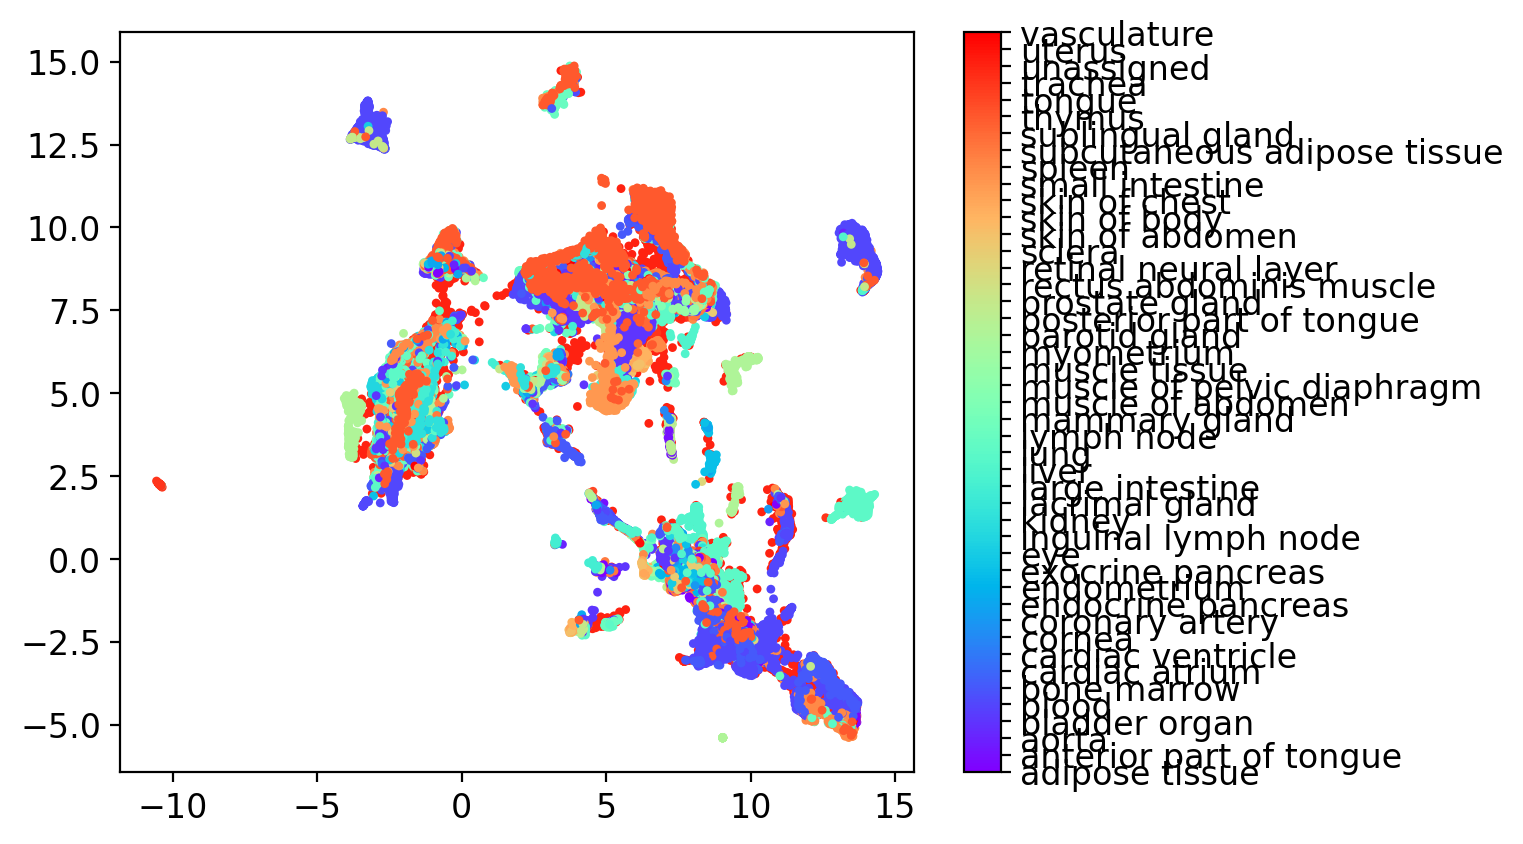

In [22]:
samap.scatter(c='hs_tissue')


In [23]:
#Using cell type annotation instead of tissue.
keys_ct = {'pw':'seurat_clusters','hs':'cell_type'}
Ct,MappingTable_ct = get_mapping_scores(sm,keys_ct,n_top = 0)
Ct.head()
Ct.to_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Final_Data/Output_ct_map_pw&hs.csv")
MappingTable_ct.head()
MappingTable_ct.to_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Final_Data/Mappingtable_ct_pw&hs.csv")
Ct.head()

pw_15                 hs_neutrophil                  \
                 Cluster Alignment score       Cluster Alignment score   
0          hs_neutrophil        0.867443         pw_15        0.867443   
1  hs_classical monocyte        0.006365         pw_18        0.700754   
2              hs_B cell        0.002863          pw_9        0.621855   
3          hs_macrophage        0.001086         pw_12        0.514546   
4    hs_mature NK T cell        0.000979          pw_7        0.261986   

  hs_platelet                                                   pw_6  \
      Cluster Alignment score                                Cluster   
0        pw_6        0.855147                            hs_platelet   
1        pw_8        0.221598                  hs_classical monocyte   
2       pw_10        0.072321           hs_erythroid progenitor cell   
3       pw_14        0.035576  hs_mature conventional dendritic cell   
4       pw_20        0.006782           hs_common myeloid progenitor   

                                                       pw_18                  \
  Alignment score                                    Cluster Alignment score   
0        0.855147                              hs_neutrophil        0.700754   
1        0.027134                      hs_classical monocyte        0.019107   
2        0.010431                              hs_macrophage        0.003361   
3        0.007209                                hs_monocyte        0.002713   
4        0.006702  hs_CD8-positive, alpha-beta memory T cell        0.001259   

   ...           hs_plasmablast                  \
   ...                  Cluster Alignment score   
0  ...                     pw_2        0.029272   
1  ...                    pw_14        0.019428   
2  ...                     pw_4        0.009805   
3  ...                     pw_0             0.0   
4  ...  hs_innate lymphoid cell             0.0   

           hs_liver dendritic cell                  \
                           Cluster Alignment score   
0                             pw_0        0.028127   
1                             pw_5        0.001295   
2  hs_immature natural killer cell             0.0   
3                     hs_mast cell             0.0   
4                    hs_macrophage             0.0   

                      hs_Langerhans cell                  \
                                 Cluster Alignment score   
0                                   pw_0        0.009707   
1                                   pw_7        0.003145   
2                                   pw_5        0.001831   
3  hs_mature conventional dendritic cell             0.0   
4                           hs_mast cell             0.0   

  hs_double-positive, alpha-beta thymocyte                  \
                                   Cluster Alignment score   
0                                     pw_0        0.009383   
1               hs_hematopoietic stem cell             0.0   
2                             hs_mast cell             0.0   
3                            hs_macrophage             0.0   
4                  hs_liver dendritic cell             0.0   

    hs_erythroid lineage cell                  
                      Cluster Alignment score  
0                        pw_0             0.0  
1  hs_hematopoietic stem cell             0.0  
2                hs_mast cell             0.0  
3               hs_macrophage             0.0  
4     hs_liver dendritic cell             0.0  

[5 rows x 152 columns]

In [24]:
chord_plot(MappingTable_ct, align_thr=0.3)

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in

:Chord   [source,target]   (value,edge_grp)

<Axes: >

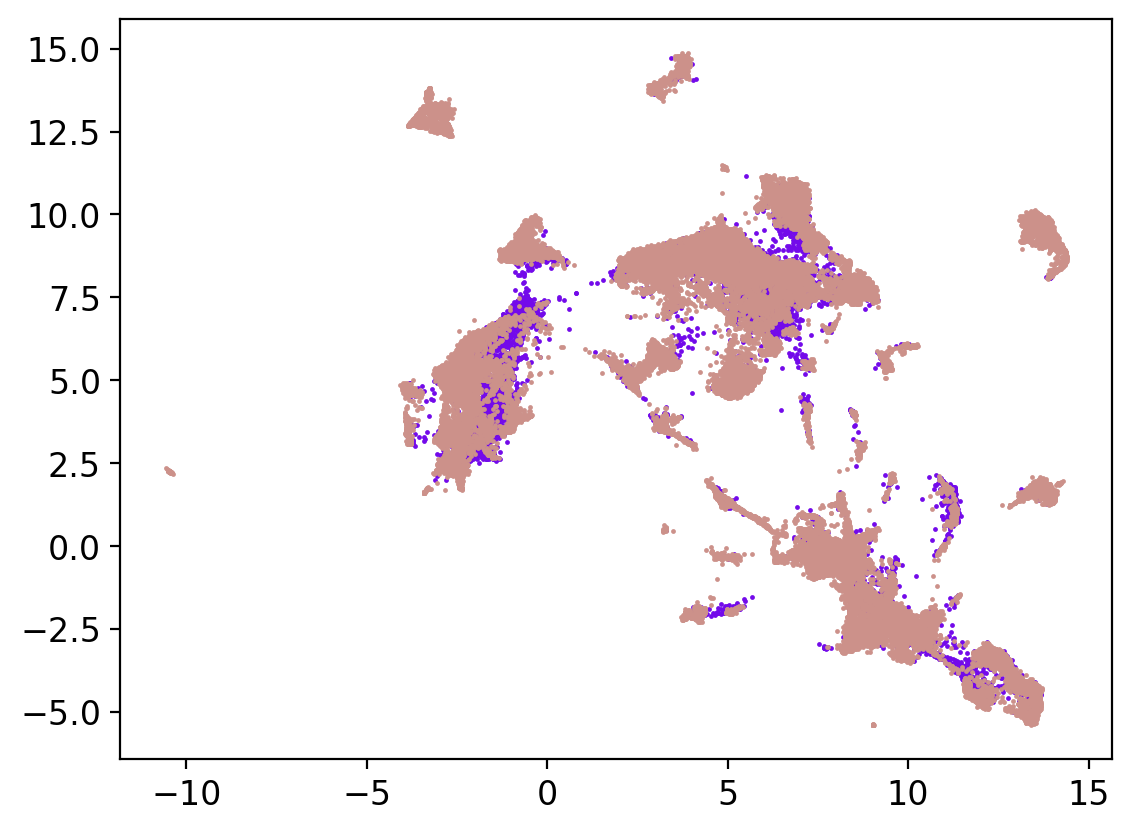

In [25]:
sm.scatter()

<Axes: >

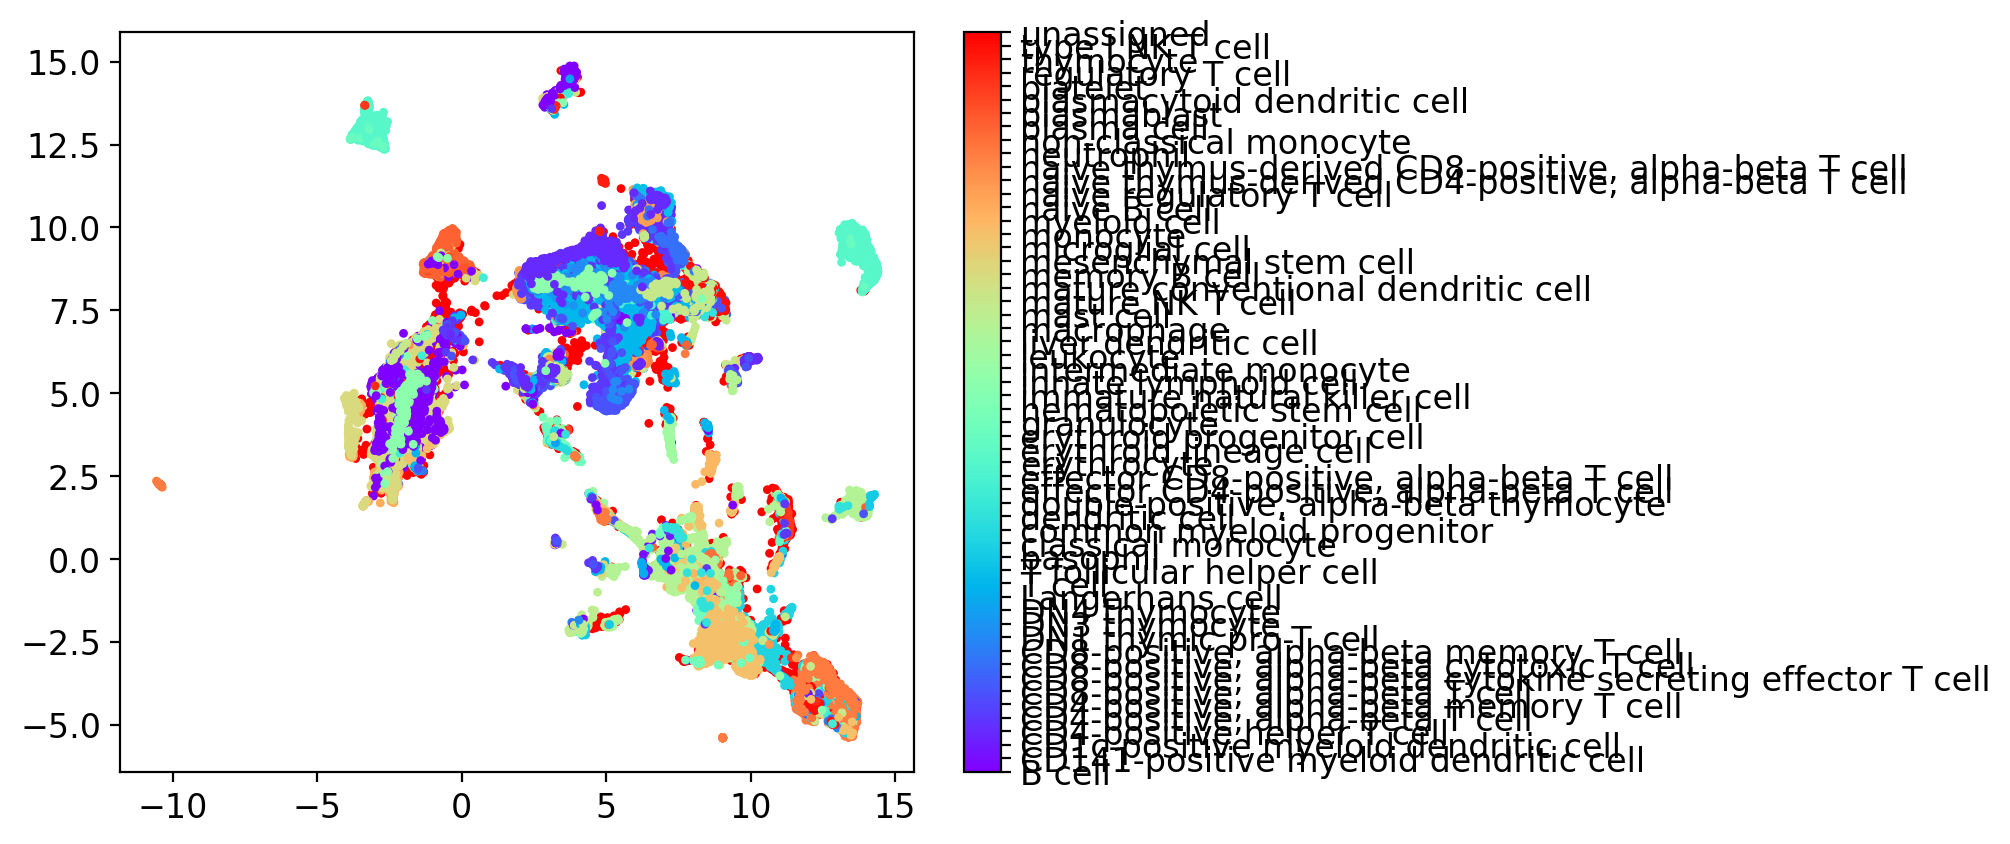

In [26]:
samap.scatter(c='hs_cell_type')

<Axes: >

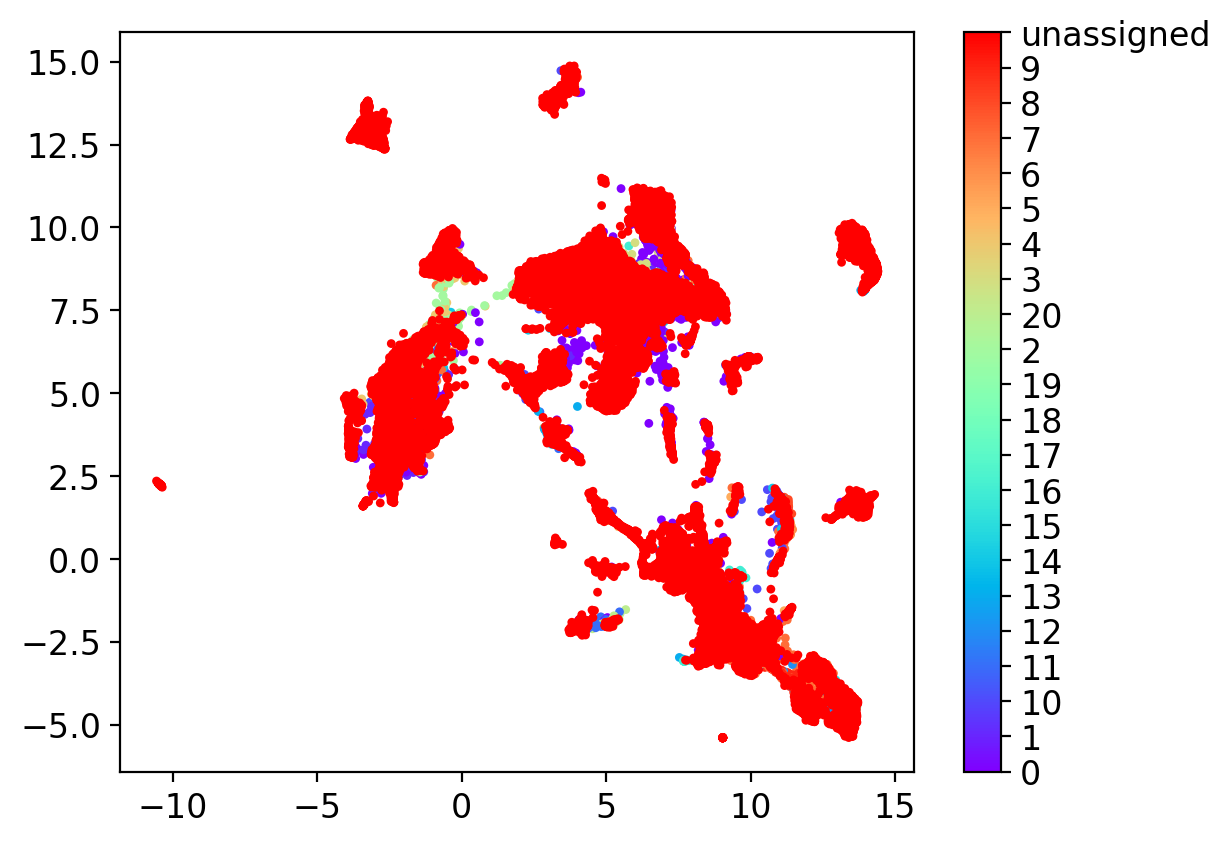

In [27]:
samap.scatter(c='pw_seurat_clusters')

<Axes: >

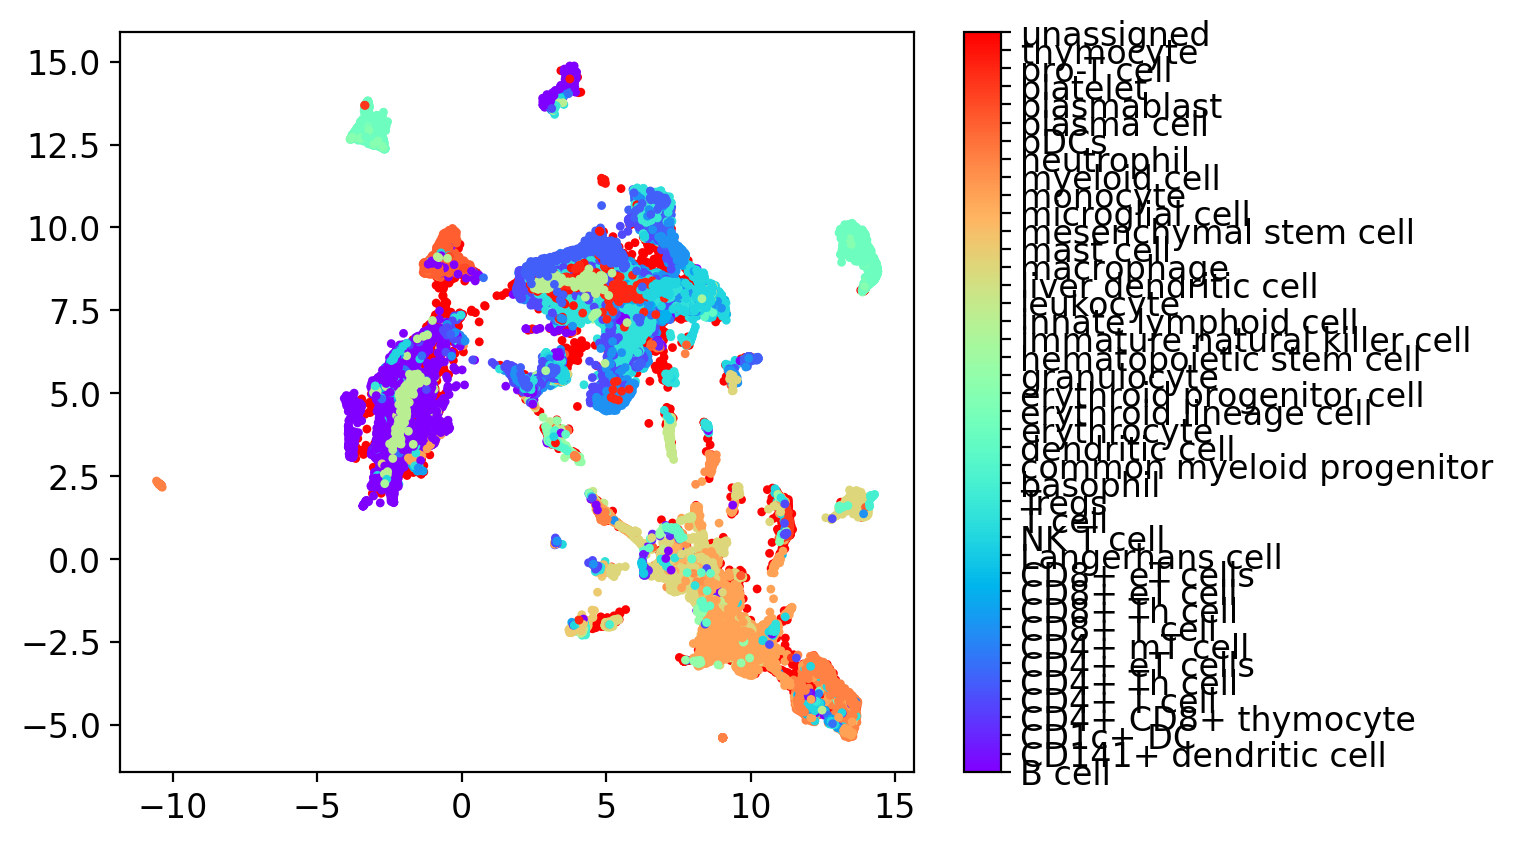

In [28]:
#Extract the cell_type column from the samap.adata.obs
cell_types=samap.adata.obs['hs_cell_type']
#Extract all the distinct cell types
cell_types_unique=cell_types.unique()
#Combine similar cell_types to one category
cell_types_hs_plot = cell_types.replace("liver dendritic cells","dendritic cells").replace("mature NK T cell","NK T cell").replace("CD8-positive, alpha-beta T cell","CD8+ T cell").replace("CD4-positive, alpha-beta T cell","CD4+ T cell").replace("double-positive, alpha-beta thymocyte","CD4+ CD8+ thymocyte").replace("CD4-positive, alpha-beta memory T cell","CD4+ mT cell").replace("CD8-positive, alpha-beta cytokine secreting effector T cell","CD8+ eT cells").replace("classical monocyte","monocyte").replace("naive B cell","B cell").replace("memory B cell","B cell").replace("type I NK T cell","NK T cell").replace("CD141-positive myeloid dendritic cell","CD141+ dendritic cell").replace("naive thymus-derived CD4-positiv, alpha-beta T cell","CD4+ T cell").replace("non-classical monocyte","monocyte").replace("effector CD8-positive, alpha-beta T cell","CD8+ eT cell").replace("effector CD4-positive, alpha-beta T cell","CD4+ eT cells").replace("regulatory T cell","Tregs").replace("CD1c-positive myeloid dendritic cell","CD1c+ DC").replace("intermediate monocyte","monocyte").replace("mature conventional dendritic cell","dendritic cell").replace("CD4-positive helper T cell","CD4+ Th cell").replace("CD8-positive, alpha-beta memory T cell","CD8+ Th cell").replace("naive thymus-derived CD8-positive, alpha-beta T cell","CD8+ T cell").replace("CD8-positive, alpha-beta cytotoxic T cell","CD8+ T cell").replace("plasmacytoid dendritic cell","pDCs").replace("naive regulatory T cell","Tregs").replace("T follicular helper cell","T cell").replace("DN4 thymocyte","thymocyte").replace("DN3 thymocyte","thymocyte").replace("DN1 thymic pro-T cell","pro-T cell").replace("naive thymus-derived CD4-positive, alpha-beta T cell","CD4+ T cell").replace("alpha-beta T cell","T cell")
cell_types_hs_plot.unique()
#Add a new column with the simplified cell types to the samap.adata.obs
samap.adata.obs['hs_cell_type_sim']=cell_types_hs_plot
#Plot the simplified cell types
samap.scatter(c='hs_cell_type_sim')

In [ ]:
print(samap.adata.obs_keys())

In [ ]:
#Doing it again with the simplified cell types
#Using cell type annotation instead of tissue.
keys_ct_sim = {'pw':'seurat_clusters','hs':'cell_type_sim'}
Ct_sim,MappingTable_ct_sim = get_mapping_scores(sm,keys_ct_sim,n_top = 0)

In [ ]:
gpf_ct = GenePairFinder(sm,keys=keys_ct);
gene_pairs = gpf_ct.find_all(align_thr=0.3);

In [ ]:
gene_pairs

In [29]:
#Save Gene pairs
#gene_pairs.to_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Final_Data/Gene_pairs_ct_pw&hs.csv")
#Read in the gene pairs
gene_pairs=pd.read_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Final_Data/Gene_pairs_ct_pw&hs.csv")

In [ ]:
#Drop the cells with NaN values


In [30]:
gene_pairs

,Unnamed: 0,hs_B cell;pw_1,hs_B cell;pw_1_pval1,hs_B cell;pw_1_pval2,hs_CD4-positive helper T cell;pw_3,hs_CD4-positive helper T cell;pw_3_pval1,hs_CD4-positive helper T cell;pw_3_pval2,"hs_CD4-positive, alpha-beta T cell;pw_0","hs_CD4-positive, alpha-beta T cell;pw_0_pval1","hs_CD4-positive, alpha-beta T cell;pw_0_pval2",...,hs_plasma cell;pw_14_pval2,hs_platelet;pw_6,hs_platelet;pw_6_pval1,hs_platelet;pw_6_pval2,hs_thymocyte;pw_0,hs_thymocyte;pw_0_pval1,hs_thymocyte;pw_0_pval2,hs_type I NK T cell;pw_3,hs_type I NK T cell;pw_3_pval1,hs_type I NK T cell;pw_3_pval2
0,0,hs_ENSG00000153064;pw_gene14937,0.0,0.0,hs_ENSG00000081059;pw_gene53210,0.000000e+00,0.0,hs_ENSG00000168685;pw_gene16807,0.0,1.802128e-123,...,1.324480e-07,hs_ENSG00000169704;pw_gene64519,2.427007e-38,2.609096e-288,hs_ENSG00000106018;pw_gene25142,6.115071e-53,3.486285e-04,hs_ENSG00000027075;pw_gene35822,3.344109e-81,0.000000e+00
1,1,hs_ENSG00000116191;pw_gene33013,0.0,0.0,hs_ENSG00000138795;pw_gene53210,0.000000e+00,0.0,hs_ENSG00000111796;pw_gene23053,0.0,1.671487e-18,...,9.861878e-05,hs_ENSG00000169704;pw_gene7417,2.427007e-38,0.000000e+00,hs_ENSG00000138795;pw_gene53210,2.561610e-83,1.564987e-214,hs_ENSG00000010810;pw_gene51743,1.623569e-227,0.000000e+00
2,2,hs_ENSG00000136573;pw_gene12108,0.0,0.0,hs_ENSG00000152495;pw_gene35822,9.976999e-271,0.0,hs_ENSG00000198851;pw_gene26276,0.0,3.808794e-81,...,1.127446e-24,hs_ENSG00000165682;pw_gene32908,2.694949e-27,3.457229e-251,hs_ENSG00000173585;pw_gene19083,5.282920e-74,6.888068e-06,hs_ENSG00000010810;pw_gene28407,1.623569e-227,8.537812e-257
3,3,hs_ENSG00000116191;pw_gene33906,0.0,0.0,hs_ENSG00000113263;pw_gene51743,0.000000e+00,0.0,hs_ENSG00000213145;pw_gene13943,0.0,1.545816e-16,...,5.156694e-03,hs_ENSG00000259207;pw_gene44742,3.728509e-28,0.000000e+00,hs_ENSG00000173585;pw_gene58717,5.282920e-74,7.025616e-06,hs_ENSG00000074966;pw_gene51743,2.165033e-92,0.000000e+00
4,4,hs_ENSG00000138639;pw_gene14672,0.0,0.0,hs_ENSG00000152495;pw_gene15882,9.976999e-271,0.0,hs_ENSG00000167286;pw_gene26275,0.0,5.334035e-51,...,5.156694e-03,hs_ENSG00000101162;pw_gene51055,7.326514e-33,4.229733e-306,hs_ENSG00000173585;pw_gene16284,5.282920e-74,8.429166e-26,hs_ENSG00000168685;pw_gene16807,5.276453e-136,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#Load in the tsv file for mappings
mapper=pd.read_table("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/aPlwal.pri.V2.genome.annots.tsv")
mapper_dict = mapper.set_index('#gene_id')['EggNM.Preferred_name'].to_dict()
mapper_dict

FileNotFoundError: [Errno 2] No such file or directory: '/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_Data/mapper_dict.txt'

In [32]:
#Replace the pw names with the eggnoG names
for i in gene_pairs.columns:
    if not (i.endswith('pval1') or i.endswith('pval2')):
        for j in gene_pairs[i].index:
            if pd.isna(j):
                continue
            cell_value = gene_pairs.at[j, i]
            if isinstance(cell_value, str):
                hs_pw = cell_value.split(';')
                if len(hs_pw) >= 2:
                    pw = hs_pw[1].split('_')[1]
                #Use the mapper_dict to map
                    if mapper_dict[pw] != '.':
                        hs_pw[1] = mapper_dict[pw]
                        gene_pairs.at[j, i] = ';'.join(hs_pw)


In [33]:
gene_pairs

,Unnamed: 0,hs_B cell;pw_1,hs_B cell;pw_1_pval1,hs_B cell;pw_1_pval2,hs_CD4-positive helper T cell;pw_3,hs_CD4-positive helper T cell;pw_3_pval1,hs_CD4-positive helper T cell;pw_3_pval2,"hs_CD4-positive, alpha-beta T cell;pw_0","hs_CD4-positive, alpha-beta T cell;pw_0_pval1","hs_CD4-positive, alpha-beta T cell;pw_0_pval2",...,hs_plasma cell;pw_14_pval2,hs_platelet;pw_6,hs_platelet;pw_6_pval1,hs_platelet;pw_6_pval2,hs_thymocyte;pw_0,hs_thymocyte;pw_0_pval1,hs_thymocyte;pw_0_pval2,hs_type I NK T cell;pw_3,hs_type I NK T cell;pw_3_pval1,hs_type I NK T cell;pw_3_pval2
0,0,hs_ENSG00000153064;BANK1,0.0,0.0,hs_ENSG00000081059;TCF7,0.000000e+00,0.0,hs_ENSG00000168685;IL7R,0.0,1.802128e-123,...,1.324480e-07,hs_ENSG00000169704;pw_gene64519,2.427007e-38,2.609096e-288,hs_ENSG00000106018;CALCRL,6.115071e-53,3.486285e-04,hs_ENSG00000027075;PRKCQ,3.344109e-81,0.000000e+00
1,1,hs_ENSG00000116191;RALGPS2,0.0,0.0,hs_ENSG00000138795;TCF7,0.000000e+00,0.0,hs_ENSG00000111796;pw_gene23053,0.0,1.671487e-18,...,9.861878e-05,hs_ENSG00000169704;GP1BB,2.427007e-38,0.000000e+00,hs_ENSG00000138795;TCF7,2.561610e-83,1.564987e-214,hs_ENSG00000010810;pw_gene51743,1.623569e-227,0.000000e+00
2,2,hs_ENSG00000136573;TEC,0.0,0.0,hs_ENSG00000152495;PRKCQ,9.976999e-271,0.0,hs_ENSG00000198851;CD3E,0.0,3.808794e-81,...,1.127446e-24,hs_ENSG00000165682;pw_gene32908,2.694949e-27,3.457229e-251,hs_ENSG00000173585;CCR2,5.282920e-74,6.888068e-06,hs_ENSG00000010810;LCK,1.623569e-227,8.537812e-257
3,3,hs_ENSG00000116191;pw_gene33906,0.0,0.0,hs_ENSG00000113263;pw_gene51743,0.000000e+00,0.0,hs_ENSG00000213145;pw_gene13943,0.0,1.545816e-16,...,5.156694e-03,hs_ENSG00000259207;ITGB3,3.728509e-28,0.000000e+00,hs_ENSG00000173585;P2RY8,5.282920e-74,7.025616e-06,hs_ENSG00000074966;pw_gene51743,2.165033e-92,0.000000e+00
4,4,hs_ENSG00000138639;ARHGAP24,0.0,0.0,hs_ENSG00000152495;CAMK4,9.976999e-271,0.0,hs_ENSG00000167286;pw_gene26275,0.0,5.334035e-51,...,5.156694e-03,hs_ENSG00000101162;pw_gene51055,7.326514e-33,4.229733e-306,hs_ENSG00000173585;F2R,5.282920e-74,8.429166e-26,hs_ENSG00000168685;IL7R,5.276453e-136,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Save the gene pairs
#gene_pairs.to_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Final_Data/Tabula_Immune_Gene_pairs_ct_pw&hs_.csv")

#Load in the gene pairs
gene_pairs=pd.read_csv("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Final_Data/Tabula_Immune_Gene_pairs_ct_pw&hs_.csv")

In [7]:
#Save the gene pairs as metadata for the adata object for pw
samap.adata.obs['pw_gene_pairs']=gene_pairs


ValueError: Cannot set a DataFrame with multiple columns to the single column pw_gene_pairs

AttributeError: 'SAMAP' object has no attribute 'adata'